############# 1. Caracteristicas: 23 ###############
############# 2. Division de datos #############
############ 3. Seleccionando modelo #############
############ 4. Entrenando modelo #############
Tiempo de Hiperparametros:00:00:03
############ 5. Metricas del modelo #############
Accuracy: 99.76315789473685 
Precision: 99.76423180450654 
Recall: 99.76315789473685 
F1-Score: 99.7632302964121
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6834
           1       1.00      1.00      1.00      6841
           2       1.00      0.99      0.99      6888
           3       0.99      1.00      1.00      6795
           4       1.00      1.00      1.00      6842

    accuracy                           1.00     34200
   macro avg       1.00      1.00      1.00     34200
weighted avg       1.00      1.00      1.00     34200



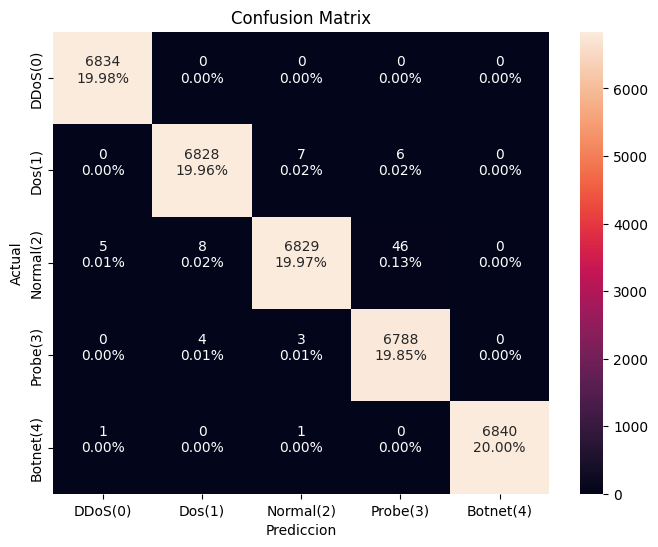

################## 6. Validar resultados de Modelo ####################
Accuracy:  99.75219298245615
Precision:  99.75383171147372
Recall:  99.75219298245615
F1-Score:  99.75234276767935


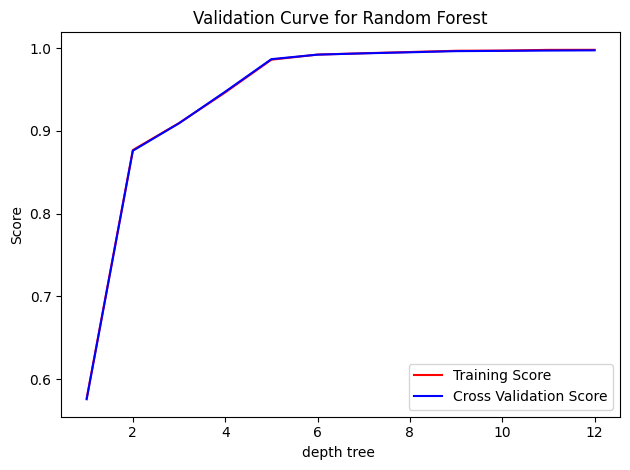

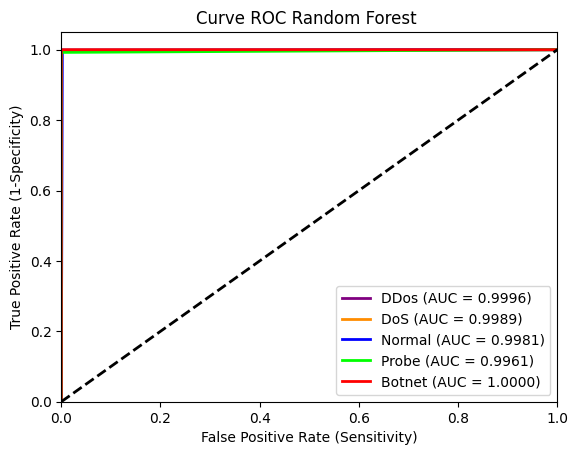

In [1]:
import pandas as pd
import numpy as np
"""graficas"""
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import cycle
"""preprocesar"""
from sklearn.preprocessing import StandardScaler, label_binarize
"""dividir datos"""
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
"""validar modelo"""
from sklearn.model_selection import validation_curve, StratifiedKFold, GridSearchCV, cross_validate
"""metricas de evaluacion"""
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, roc_curve, auc, make_scorer
"""modelos ML"""
from sklearn.ensemble import RandomForestClassifier
import time

""" crear Funcion para matriz de confusion """
def crearMatriz_confusion(y_pred,y_test):
    cm= confusion_matrix(y_pred, y_test)
    plt.figure(figsize = (8,6))

    values = ["{0:0.0f}".format(x) for x in cm.flatten()]

    """ calcular y obtener valores"""
    percentages = ["{0:.2%}".format(x) for x in cm.flatten()/np.sum(cm)]
    combined = ["{}\n{}\n".format(j, k) for j, k in zip(values, percentages)]
    combined = np.asarray(combined).reshape(5,5)
    """crear matriz"""
    b = sns.heatmap(cm, annot=combined, fmt="")
    b.set_xticklabels(['DDoS(0)','Dos(1)','Normal(2)','Probe(3)', 'Botnet(4)'],fontsize=10)
    b.set_yticklabels(['DDoS(0)','Dos(1)','Normal(2)','Probe(3)', 'Botnet(4)'],fontsize=10)
    """etiquetas"""
    b.set(title='Confusion Matrix')
    b.set(xlabel='Prediccion', ylabel='Actual',)
    plt.savefig('matrizconfusionRF_featuresG3.png')
    plt.show()

"""crear funcion para encontrar metricas del modelo """
def encontrar_metricas(y_test,y_pred):
    """ encontrar la precision del general del modelo"""
    accuracy = accuracy_score(y_test, y_pred)*100
    precision_ma = precision_score(y_test, y_pred, average='weighted')*100
    recall_ma = recall_score(y_test, y_pred, average='weighted')*100
    f1score_ma = f1_score(y_test, y_pred, average='weighted')*100
    return print('Accuracy: %s \nPrecision: %s \nRecall: %s \nF1-Score: %s' %(accuracy, precision_ma, recall_ma, f1score_ma))


df_traffic = pd.read_csv('../../balance_Tot5Clases_34200.csv', low_memory=False)
"""matriz de caracteristicas"""
caracteristicas = ['Dur', 'SrcDur', 'DstDur','protoTcp','protoUdp','portSystem','portUser','portDynamic',
                    'TotPkts', 'SrcPkts', 'DstPkts', 'TotBytes', 'SrcBytes', 'DstBytes','Rate', 'SrcRate', 'DstRate',
                    'sMeanPktSz', 'dMeanPktSz', 'sMaxPktSz', 'dMaxPktSz', 'sMinPktSz', 'dMinPktSz']
print("############# 1. Caracteristicas: %s ###############" %len(caracteristicas) )

"""seleccion de variables"""
X= df_traffic[caracteristicas].values
y=df_traffic.iloc[:,-1].values

print("############# 2. Division de datos #############")
"""division de datos"""
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=9 )

"""estandarizar datos"""
scalar = StandardScaler()
X_train = scalar.fit_transform(X_train)
X_test = scalar.transform(X_test)


print("############ 3. Seleccionando modelo #############")
inicio_hp = time.time()
"""validacion cruzada"""
skf = StratifiedKFold(n_splits=5, random_state=1, shuffle=True)
clf_rf = RandomForestClassifier(ccp_alpha=0.0001, criterion='entropy', max_depth=12,
                       min_samples_leaf=2, min_samples_split=5, n_estimators=10,
                       random_state=1)

print("############ 4. Entrenando modelo #############")
clf_rf = clf_rf.fit(X_train,y_train)
y_pred = clf_rf.predict(X_test)
print("Tiempo de Hiperparametros:" + time.strftime("%H:%M:%S", time.gmtime(time.time() - inicio_hp)))

print("############ 5. Metricas del modelo #############")
""" metricas"""
encontrar_metricas(y_test,y_pred)
print(classification_report(y_pred,y_test))#ver nro de instancias por clase
crearMatriz_confusion(y_pred,y_test)

print('################## 6. Validar resultados de Modelo ####################')
score = {'accuracy': make_scorer(accuracy_score), 'precision': make_scorer(precision_score, average='weighted'),
         'recall': make_scorer(recall_score, average='weighted'),'f1_score': make_scorer(f1_score, average= 'weighted')}

eval_resultado = cross_validate(estimator=clf_rf, X=X_train, y=y_train, cv=skf, scoring=score)
print('Accuracy: ',  (np.mean(eval_resultado['test_accuracy'])*100))
print('Precision: ', (np.mean(eval_resultado['test_precision'])*100))
print('Recall: ', (np.mean(eval_resultado['test_recall'])*100))
print('F1-Score: ', (np.mean(eval_resultado['test_f1_score'])*100))


"""Grafica de entrenamiento del modelo"""
param_range = np.arange(1, (12+1),1)
train_scores, test_scores = validation_curve(clf_rf, X_train, y_train, 
                            param_name="max_depth", param_range=param_range, cv=skf,
                                             scoring="accuracy", n_jobs=-1)
"""calcular el promedio y desviacion standar del entrenamiento """
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
"""calcular el promedio y desviacion standar del conjunto de prueba """
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

"""mostrar valores obtenidos del conjunto de entrenamiento y prueba"""
plt.plot(param_range, train_scores_mean - train_scores_std,
     label = "Training Score", color = 'r')
plt.plot(param_range, test_scores_mean - test_scores_std,
   label = "Cross Validation Score", color = 'b')
 
"""crear grafica"""
plt.title("Validation Curve for Random Forest")
plt.xlabel("depth tree ")
plt.ylabel("Score")
plt.tight_layout()
plt.legend(loc = 'best')
plt.savefig('RF_curve_featuresG3.png')
plt.show()

"""CURVA ROC"""
y_lbtest = label_binarize(y_test,classes=[0, 1, 2, 3, 4])
y_lbpred = label_binarize(y_pred,classes=[0, 1, 2, 3, 4])
fpr = dict()
tpr = dict()
thresh=dict()
roc_auc = dict()
for i in range(5):
    fpr[i], tpr[i], thresh[i] = roc_curve(y_lbtest[:,i], y_lbpred[:,i] )
    roc_auc[i] = auc(fpr[i], tpr[i])
colors = cycle(['purple', 'darkorange','blue','lime', 'red'])
clases = ['DDos','DoS', 'Normal', 'Probe', 'Botnet']
for i, color, clase in zip(range(5), colors, clases):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='{0} (AUC = {1:0.4f})'
             ''.format(clase, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (Sensitivity)')
plt.ylabel('True Positive Rate (1-Specificity)')
plt.title('Curve ROC Random Forest ')
plt.legend(loc="lower right")
plt.savefig('RF_roc_featuresG3.png')
plt.show()

In [3]:
"""guardar los modelos"""
import pickle 
import joblib
pickle.dump(clf_rf,open('p_rf_FG1.pkl','wb'))
joblib.dump(clf_rf, 'j_rf_FG1.sav')

['j_rf_FG1.sav']